# Analysis of Seattle Airbnb data from April 2016

This project will attempt to answer a set of questions using the Seattle Airbnb dataset

First, we will import the necessary libraries and gather the data by importing CSV files provided by Airbnb into pandas dataframes

In [1]:
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

pd.options.mode.copy_on_write = True

df = pd.read_csv('./listings.csv')
df_rev = pd.read_csv('./reviews.csv')
df_adj = pd.read_csv('./adjectives.csv')

print('Number of listings: ' + str(df.shape[0])) # Listings contains data about each property, there are 3818 properties in this dataset
print('Number of attributes: ' + str(df.shape[1])) # This dataset has 92 columns providing a wealth of data points for each listing
print(df.columns)



Number of listings: 3818
Number of attributes: 92
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathroom

### Column data types
It's going to help me to understand how to interpret the data if I can categorise the various different data types available to me
Let's try and identify the numerical columns

In [5]:
print('There are ' + str(len(df.dtypes[df.dtypes == 'int64'])) + ' columns of type int64:')
print(df.dtypes[df.dtypes == 'int64'])
print('There are ' + str(len(df.dtypes[df.dtypes == 'float64'])) + ' columns of type float64')
print(df.dtypes[df.dtypes == 'float64'])

There are 13 columns of type int64:
id                                int64
scrape_id                         int64
host_id                           int64
accommodates                      int64
guests_included                   int64
minimum_nights                    int64
maximum_nights                    int64
availability_30                   int64
availability_60                   int64
availability_90                   int64
availability_365                  int64
number_of_reviews                 int64
calculated_host_listings_count    int64
dtype: object
There are 17 columns of type float64
host_listings_count            float64
host_total_listings_count      float64
latitude                       float64
longitude                      float64
bathrooms                      float64
bedrooms                       float64
beds                           float64
square_feet                    float64
review_scores_rating           float64
review_scores_accuracy         float64
rev

## Category columns
From the remaining 62 text columns (datatype = object), can we determine if any are categories - these would be columns with a low number of unique values but more than 1 unique value

In [6]:
for column in df.columns:
	if df[str(column)].dtype == 'object' and len(df[str(column)].unique()) < 100 and len(df[str(column)].unique()) > 1:
		print('There are ' + str(len(df[str(column)].unique())) + '\tunique values in column: ' + str(column))

There are 5	unique values in column: host_response_time
There are 46	unique values in column: host_response_rate
There are 3	unique values in column: host_acceptance_rate
There are 3	unique values in column: host_is_superhost
There are 3	unique values in column: host_has_profile_pic
There are 3	unique values in column: host_identity_verified
There are 82	unique values in column: neighbourhood
There are 87	unique values in column: neighbourhood_cleansed
There are 17	unique values in column: neighbourhood_group_cleansed
There are 7	unique values in column: city
There are 2	unique values in column: state
There are 29	unique values in column: zipcode
There are 7	unique values in column: smart_location
There are 2	unique values in column: is_location_exact
There are 17	unique values in column: property_type
There are 3	unique values in column: room_type
There are 5	unique values in column: bed_type
There are 47	unique values in column: security_deposit
There are 45	unique values in column: 

### Complete columns

Let's also try and find which columns are well populated for each property. These will be easier to work with as we won't have to worry about missing data

In [7]:
for column in df.columns:
	if df[str(column)].isnull().sum() < 100:
		print('There are ' + str(df[str(column)].isnull().sum()) + '\tnull values in column: ' + str(column))

There are 0	null values in column: id
There are 0	null values in column: listing_url
There are 0	null values in column: scrape_id
There are 0	null values in column: last_scraped
There are 0	null values in column: name
There are 0	null values in column: description
There are 0	null values in column: experiences_offered
There are 0	null values in column: picture_url
There are 0	null values in column: host_id
There are 0	null values in column: host_url
There are 2	null values in column: host_name
There are 2	null values in column: host_since
There are 8	null values in column: host_location
There are 2	null values in column: host_is_superhost
There are 2	null values in column: host_thumbnail_url
There are 2	null values in column: host_picture_url
There are 2	null values in column: host_listings_count
There are 2	null values in column: host_total_listings_count
There are 0	null values in column: host_verifications
There are 2	null values in column: host_has_profile_pic
There are 2	null valu

### Useful columns
There are quite a lot of neighbourhoods mentioned, the column neighbourhood_group_cleansed with 17 unique values is likely to be more useful to me than the related columns with over 80 unique values each

The price column is fully populated, unlike the weekly_price and monthly_price columns, perhaps price is per night and the other two columns can be calculated from price

### Questions
Looking at the data available, a number of questions occur to me, I'll try and use the data to answer some of them below

#### Question 1
Which columns have the greatest effect on the price?
I see a number of candidates:

1. neighbourhood_group_cleansed (Categorical)
2. property_type (Categorical)
3. room_type (Categorical)
4. accommodates (Numerical)
5. bathrooms (Numerical)
6. bedrooms (Numerical)
7. beds (Numerical)
8. bed_type (Categorical)

Let's try and plot the numerical correlations for these columns

<Axes: >

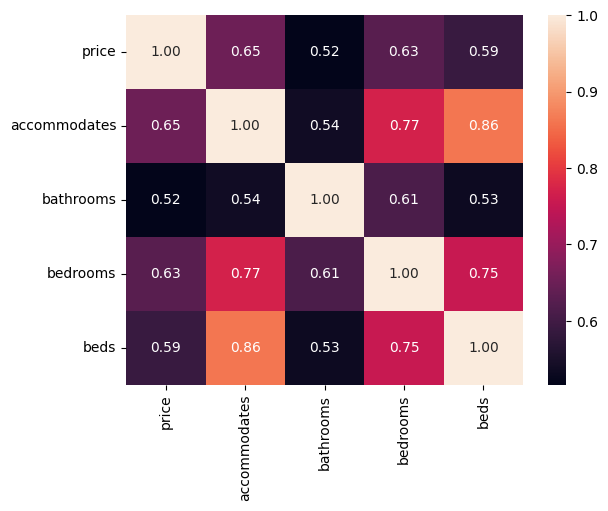

In [8]:
df_num = df[['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds']]
df_num['price'] = df_num['price'].replace('[\$,]', '', regex=True).astype(float) # price needs to be converted to numerical by removing the dollar sign and converting to float

sns.heatmap(df_num.corr(numeric_only = True), annot=True, fmt=".2f")

#### Numerical columns result
Each of the selected columns has a fairly strong correlation to the price, ordered as below:
1. accomodates (0.65) - The number of people who can stay at the property, it makes sense that this has a strong positive correlation to price
2. bedrooms (0.63) - The number of bedrooms at the property, this attribute is also heavily related to accomodates which again is as we would imagine
3. beds (0.59) - Number of beds. Heavily related to bedrooms, in fact the highest correlations are between the top three attributes (0.86, 0.77. 0.75)
4. bathrooms (0.52) - Number of bathrooms. The weakest numerical correlation, perhaps unsurprisingly

#### Categorical columns
Let's convert the categories into boolean columns and see if we can identify the desirable (higher priced) values

In [9]:
print('Neighbourhoods:')
print(set(df.neighbourhood_group_cleansed.unique()))
print('Property types:')
print(set(df.property_type.unique()))
print('Room types:')
print(set(df.room_type.unique()))
print('Bed types:')
print(set(df.bed_type.unique()))


Neighbourhoods:
{'Seward Park', 'University District', 'Downtown', 'Queen Anne', 'Capitol Hill', 'Magnolia', 'Ballard', 'Lake City', 'Rainier Valley', 'Interbay', 'Cascade', 'Other neighborhoods', 'Northgate', 'Central Area', 'Beacon Hill', 'Delridge', 'West Seattle'}
Property types:
{'Tent', 'Townhouse', 'Dorm', 'Condominium', 'Bungalow', 'Loft', 'Chalet', 'Treehouse', 'Cabin', 'House', 'Other', 'Yurt', nan, 'Apartment', 'Boat', 'Bed & Breakfast', 'Camper/RV'}
Room types:
{'Private room', 'Shared room', 'Entire home/apt'}
Bed types:
{'Airbed', 'Pull-out Sofa', 'Real Bed', 'Couch', 'Futon'}


##### Room type
We can start with room_type as it is a simple one with only three categories, for simplicity let's call the boolean columns 'Shared', 'Private' and 'Entire'

<Axes: >

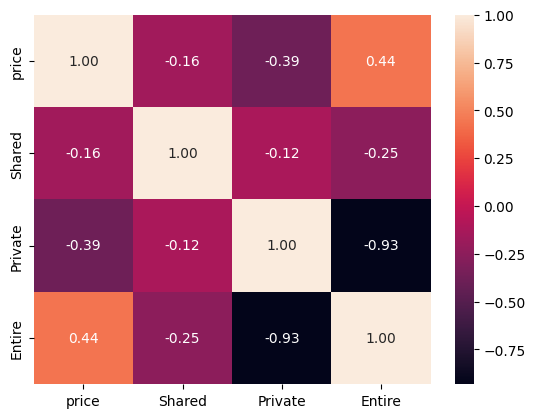

In [10]:
df_room = df[['price', 'room_type']]
df_room['price'] = df_room['price'].replace('[\$,]', '', regex=True).astype(float)
df_room['Shared'] = np.where(df_room['room_type'] == 'Shared room', 1, 0)
df_room['Private'] = np.where(df_room['room_type'] == 'Private room', 1, 0)
df_room['Entire'] = np.where(df_room['room_type'] == 'Entire home/apt', 1, 0)

sns.heatmap(df_room.corr(numeric_only = True), annot=True, fmt=".2f")

##### Room type findings

A strong positive correlation for 'Entire Home/apt'
A strong negative correlation for 'Private room'
A moderate negative correlation for 'Shared room'

This suggests that renting the entire property is far more desirable than the alternatives

##### Bed type
Bed types are: 'Airbed', 'Real Bed', 'Futon', 'Couch', 'Pull-out Sofa'
Let's perform the same exercise

<Axes: >

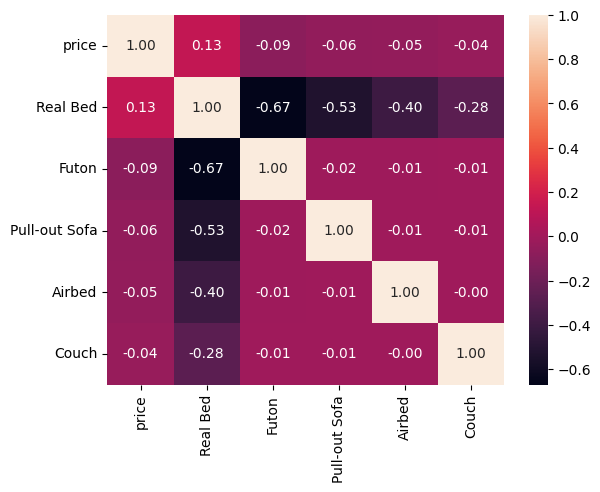

In [11]:
df_bed = df[['price', 'bed_type']]
df_bed['price'] = df_bed['price'].replace('[\$,]', '', regex=True).astype(float)
for btype in df.bed_type.unique():
	df_bed[btype] = np.where(df_bed['bed_type'] == btype, 1, 0) # Looping through saves writing one line per type

sns.heatmap(df_bed.corr(numeric_only = True), annot=True, fmt=".2f")

##### Bed type findings
A weak positive correlation for 'Real bed'
Very weak negative correlations for all other bed types

##### Property type
There are 17 of these, let's hope it doesn't overwhelm the heat map

<Axes: >

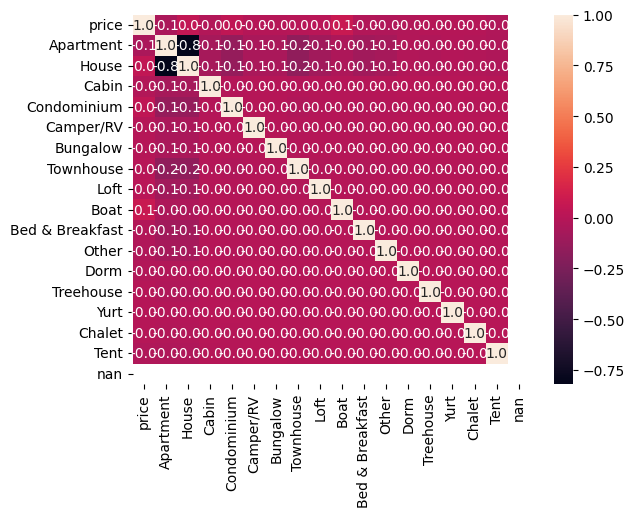

In [12]:
df_prop = df[['price', 'property_type']]
df_prop['price'] = df_prop['price'].replace('[\$,]', '', regex=True).astype(float)
for ptype in df.property_type.unique():
	df_prop[ptype] = np.where(df_prop['property_type'] == ptype, 1, 0) # Looping through saves writing one line per type

sns.heatmap(df_prop.corr(numeric_only = True), annot=True, fmt=".1f")

##### Property type findings
Very weak correlations across the board, the only slight detections are a tiny positive correlation for 'Boat' and a tiny negative correlation for 'Apartment'

##### Neighbourhoods
Let's remove the 'Other neighborhoods' category as it won't give us any information about which neighbourhoods are more desirable

<Axes: >

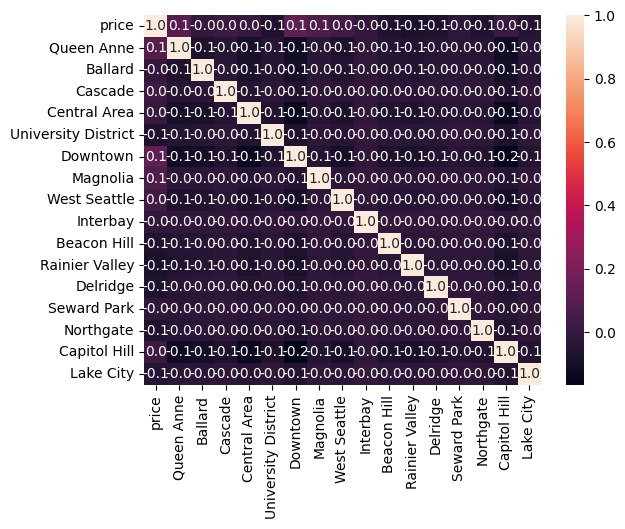

In [13]:
df_nb = df[['price', 'neighbourhood_group_cleansed']]
df_nb['price'] = df_nb['price'].replace('[\$,]', '', regex=True).astype(float)
for ntype in df.neighbourhood_group_cleansed.unique():
	df_nb[ntype] = np.where(df_nb['neighbourhood_group_cleansed'] == ntype, 1, 0)
df_nb = df_nb.drop('Other neighborhoods', axis=1)

sns.heatmap(df_nb.corr(numeric_only = True), annot=True, fmt=".1f")

##### Neighbourhood findings
Again very weak correlations across the board, we can just about discern very small differences:
1. Positive:
- Queen Anne
- Downtown
- Magnolia
2. Negative:
- University District
- Rainier Valley
- Northgate
- Lake City

## Overall findings

- The biggest impact on price is the number of beds/baths/occupants the property supports, this is perhaps no surprise
- The other factors do make a difference, with the room type of 'Entire House/apt' having the most impact beyond number of beds/baths etc.
- Property type and neighborhood have neglible impact on price

#### Box plot illustration
Let's illustrate the relationship between the number of guests accomodated with the price per night

Text(0, 0.5, 'Price ($)')

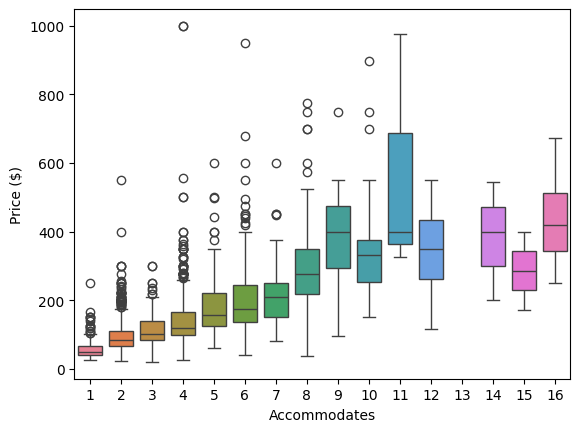

In [14]:
df_box = df[['price', 'accommodates']]
df_box['price'] = df_box['price'].replace('[\$,]', '', regex=True).astype(float)
for numb in range(1, 17):
	df_box[numb] = np.where(df_box['accommodates'] == numb, df_box['price'], None)
df_box = df_box.drop('accommodates', axis=1)
df_box = df_box.drop('price', axis=1)

sns.boxplot(data=df_box)
plt.xlabel("Accommodates")
plt.ylabel("Price ($)")

#### Question 2
Do hosts with more experience get better review scores?

The dataset contains the following columns we might use to answer this question:
- host_id - The host_id column identifies the host as they may have multiple properties
- host_since - This is a date column with the start date of the host
- calendar_last_scraped - this is the date the data was taken so we should take the difference between calendar_last_scraped and host_since to get the duration
- review_scores_rating - This is a percentage score of the property, for hosts with multiple properties, we should take the average (mean) of this value

(-5.0, 105.0)

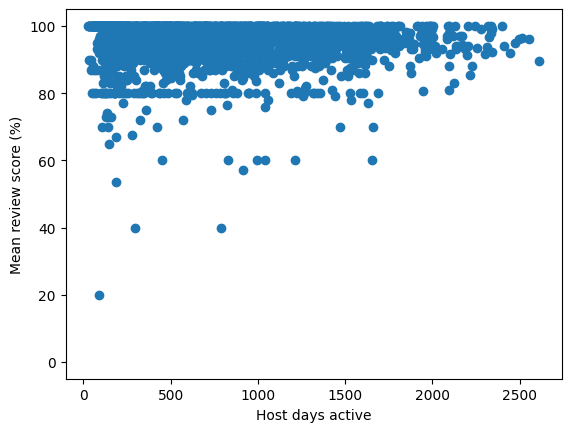

In [15]:
df_host = df[['host_id', 'host_since', 'calendar_last_scraped', 'review_scores_rating']] # Take the relevant columns
df_host['host_since'] = pd.to_datetime(df_host['host_since']) # Convert to datetime
df_host['calendar_last_scraped'] = pd.to_datetime(df_host['calendar_last_scraped']) # Convert to datetime
df_host['days_active'] = (df_host['calendar_last_scraped'] - df_host['host_since']) # Calculate difference in dates
df_host['days_active'] = df_host['days_active'] / np.timedelta64(1, 'D') # Divide by a single day to convert to numerical
df_host = df_host.drop('host_since', axis=1) # Drop date columns
df_host = df_host.drop('calendar_last_scraped', axis=1) # Drop date columns
df_mean = df_host.groupby('host_id').mean()

plt.scatter(df_mean['days_active'], df_mean['review_scores_rating'])
plt.xlabel("Host days active")
plt.ylabel("Mean review score (%)")
plt.ylim(-5, 105)

#### Answer 2 - findings

The displayed scatterplot is quite interesting, although the most noticeable feature is that the majority of reviews are positive, we can note the following features:

1. Most reviews are between 90 and 100 percent
2. The horizontal line at 80% suggests that the review/feedback form contains elements that promote giving a score of 80 over other close scores (79, 81)
3. It is possible to draw a dividing line from the origin to the top-right area of the plot keeping all points to one side of the line
4. Hosts with little experience mostly get high scores but sometimes get low scores
5. Hosts with a lot of experience _never_ get low scores

Point 3 is sufficient to answer the question: "Do hosts with more experience get better review scores?" with a Yes!

Although perhaps the more interesting findings are points 4 and 5!

#### Question 3
Which adjectives are mostly associated with positve review scores and which are mostly associated with negative review scores?

I've located a list of 4800 English adjectives to compare with the review data found at https://patternbasedwriting.com/elementary_writing_success/list-4800-adjectives/

Now let's see if we can score them. My plan is to link the review text from the reviews dataset to the review scores in the main dataset via the listings id. Next I need to check for the presence of each adjective in each review and start to build an average review score for each adjective

In [78]:
review_scores = {} # Create dictionary of review scores per listing id
for listing in df.iterrows():
	review_scores[listing[1]['id']] = listing[1]['review_scores_rating']

adj_scores = []
for adj in df_adj.iterrows():
	row = {}
	adjective = adj[1]['name']
	row['adjective'] = adjective
	row['count'] = 0
	row['score'] = 0
	row['mean'] = None
	for review in df_rev.iterrows():
		count = str(review[1]['comments']).lower().count(' ' + adjective + ' ')
		if count > 0:
			row['count'] += count
			row['score'] += (review_scores[review[1]['listing_id']] * count)
	if row['count'] > 0:
		row['mean'] = row['score'] / row['count']
	adj_scores.append(row)
	print(adjective + ': ' + str(row['mean']))

df_adj_scored = pd.DataFrame(adj_scores) # Save results to a dataframe
df_adj_scored.to_csv('./adjectives_scored.csv') # Write dataframe to CSV (as this block takes a long time to execute)

abandoned: 93.0
abdominal: None
abhorrent: None
abiding: 93.0
abject: None
able: 94.80499116607774
able-bodied: None
abnormal: 91.33333333333333
abounding: 91.0
abrasive: None
abrupt: 96.0
absent: 95.0
absentminded: None
absolute: 96.3076923076923
absorbed: 93.0
absorbing: 97.0
abstracted: None
absurd: None
abundant: 95.74603174603175
abusive: None
abysmal: None
academic: 95.0
acceptable: 88.91666666666667
accepting: 95.06060606060606
accessible: 95.23674588665448
accidental: 95.5
acclaimed: None
accommodating: 94.9498982706002
accompanying: 95.22222222222223
accountable: 97.0
accurate: 94.15586419753086
accusative: None
accused: 89.6
accusing: None
acerbic: None
achievable: None
aching: 97.0
acid: None
acidic: None
acknowledged: 75.8
acoustic: 97.66666666666667
acrid: None
acrimonious: None
acrobatic: None
actionable: None
active: 95.27173913043478
actual: 93.24102564102564
adhoc: None
adamant: 96.75
adaptable: 95.25
adaptive: None
addicted: 96.33333333333333
addictive: 97.0
additiona

#### Examining the results

This block took a long time to run, so I;ve saved the results to a CSV file so they can just be loaded from there in future

I'm going to remove entries that only appeared in a small number of reviews to avoid unusual reviews skewing the results, then show the top 50 (positive adjectives) and bottom 50 (negative adjectives) in word clouds with the number of appearances affecting the size of each word

(-0.5, 2999.5, 1999.5, -0.5)

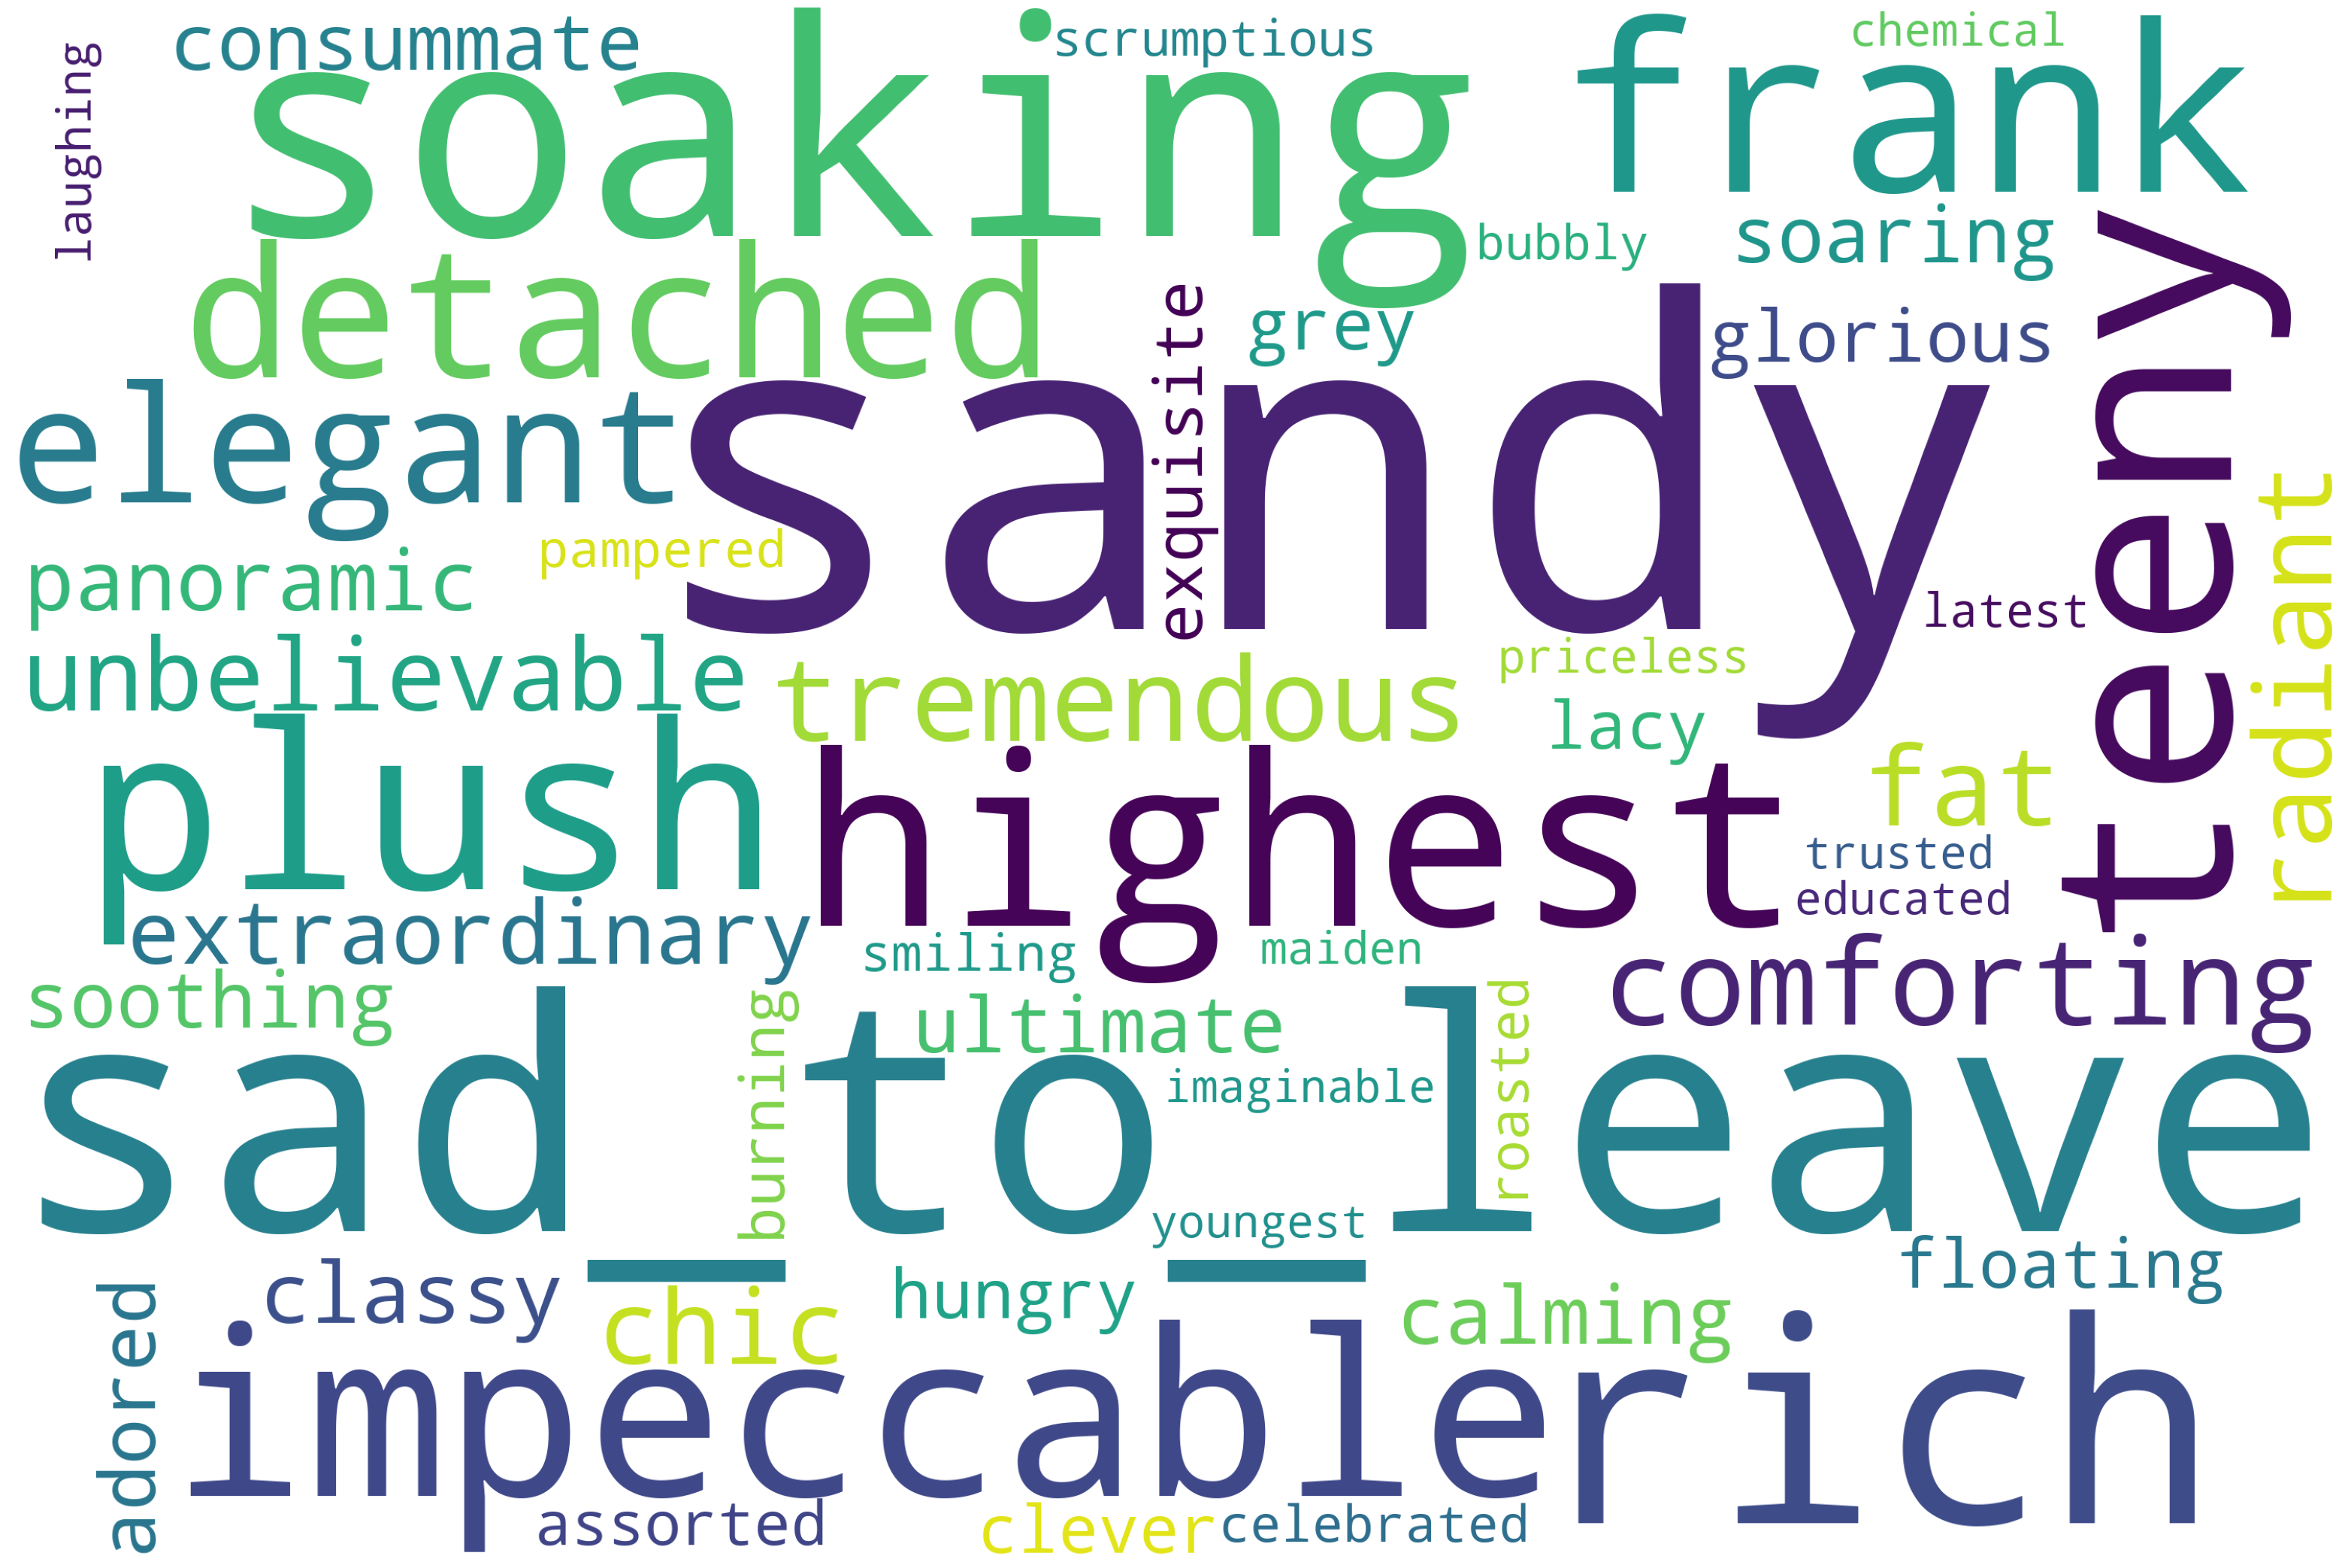

In [32]:
df_adj_scored = pd.read_csv('./adjectives_scored.csv')

df_pop = df_adj_scored[df_adj_scored['count'] > 10] # Remove unpopular words (low count score)
df_pop = df_pop.drop('score', axis=1) # Drop score column
df_pop = df_pop.drop(df_pop.columns[0], axis=1) # Drop ID column

df_pos = df_pop.sort_values(by=['mean'], ascending = False).head(50) # Take the top 50 positive adjectives
df_pos = df_pos.drop('mean', axis=1) # Drop mean column

pos_list = []
for pos_adj in df_pos.iterrows():
	adjective = pos_adj[1]['adjective']
	count = pos_adj[1]['count']
	for p in range(count):
		if adjective == 'sad':
			pos_list.append('sad_to_leave')
		else:
			pos_list.append(adjective)

wordcloud = WordCloud(width= 3000, height = 2000, background_color='white', random_state=1, collocations=False).generate(' '.join(pos_list))
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 2999.5, 1999.5, -0.5)

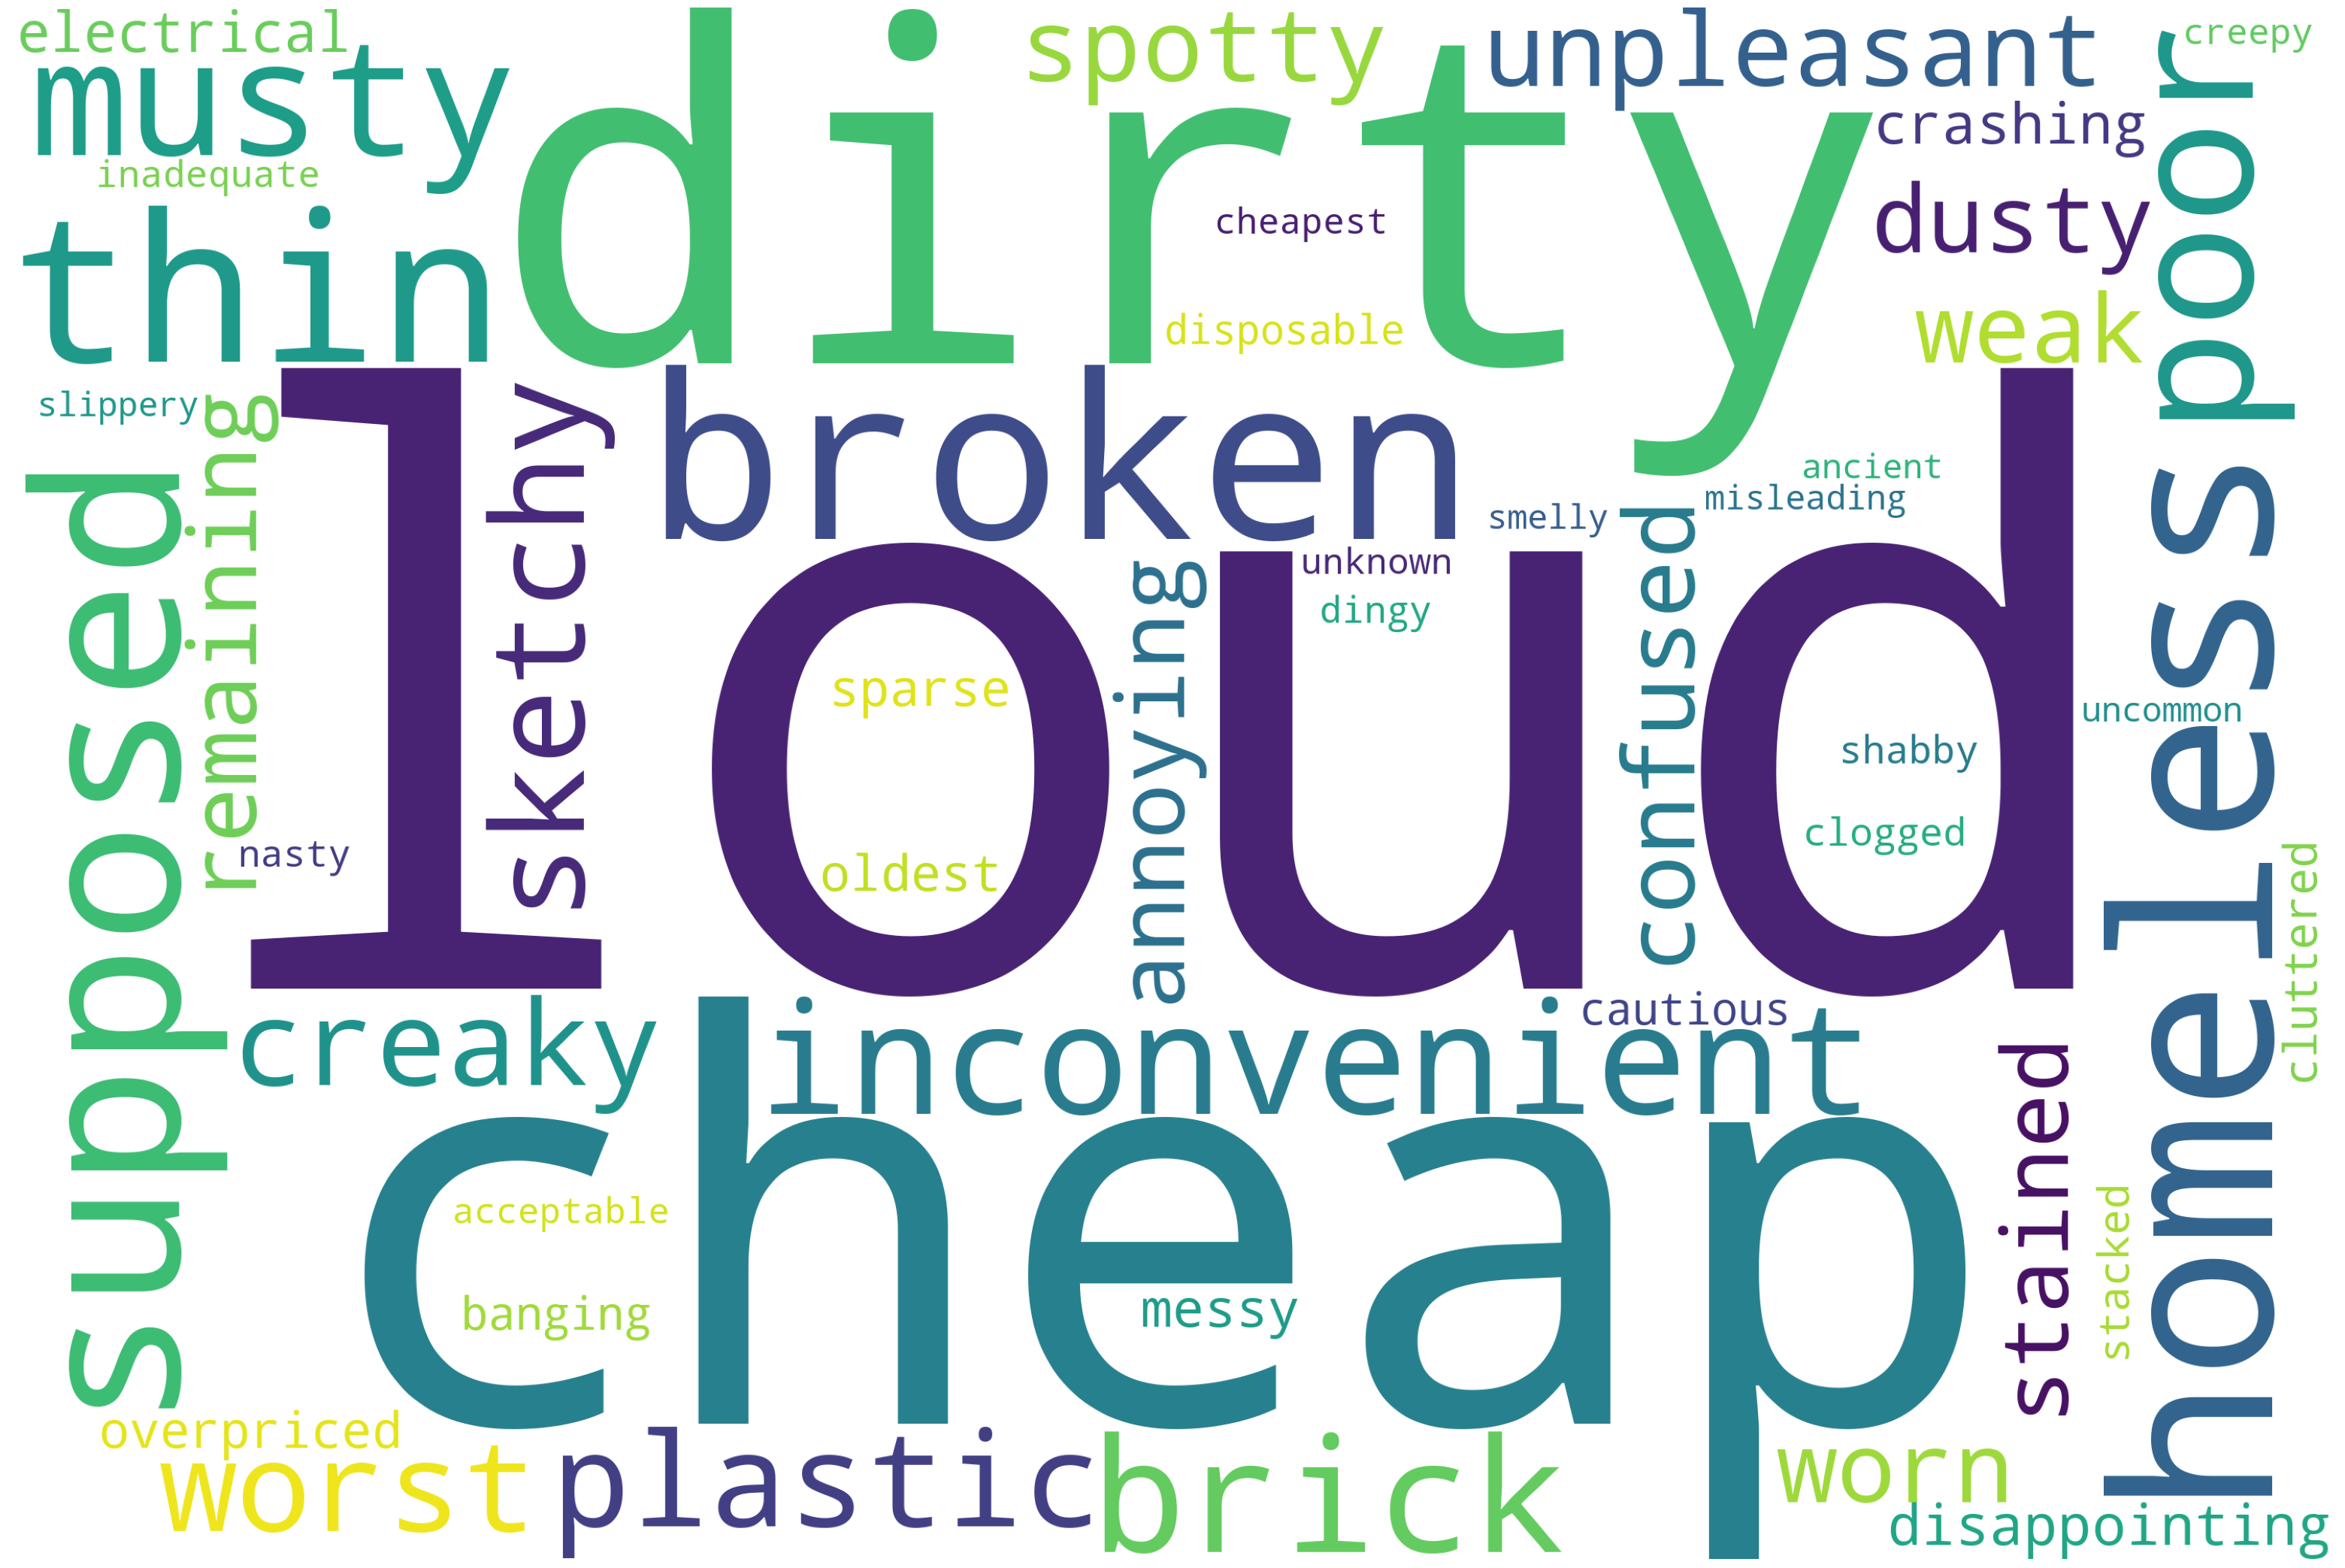

In [23]:
df_adj_scored = pd.read_csv('./adjectives_scored.csv')

df_pop = df_adj_scored[df_adj_scored['count'] > 10] # Remove unpopular words (low count score)
df_pop = df_pop.drop('score', axis=1) # Drop score column
df_pop = df_pop.drop(df_pop.columns[0], axis=1) # Drop ID column

df_neg = df_pop.sort_values(by=['mean'], ascending = True).head(50) # Take the top 50 negative adjectives
df_neg = df_neg.drop('mean', axis=1) # Drop mean column

neg_list = []
for neg_adj in df_neg.iterrows():
	adjective = neg_adj[1]['adjective']
	count = neg_adj[1]['count']
	for n in range(count):
		neg_list.append(adjective)

wordcloud = WordCloud(width= 3000, height = 2000, background_color='white', random_state=1, collocations=False).generate(' '.join(neg_list))
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis('off')